In [1]:
# Municipality Bus Utilization with TES, SARIMA and LGBM Models #

In [2]:
# Importing Libraries

import optuna
import datetime
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from scipy import stats
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from hyperopt import tpe, hp, fmin, Trials
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

In [3]:
# Reading Dataset and Printing the First 10 Items from Dataframe

filename = "municipality_bus_utilization.csv"
df = pd.read_csv(filename, parse_dates=['timestamp'])

df.head(10)

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
5,2017-06-04 07:59:42,5,70,587
6,2017-06-04 07:59:42,2,273,697
7,2017-06-04 07:59:42,1,129,397
8,2017-06-04 07:59:42,6,597,3113
9,2017-06-04 07:59:42,3,623,1930


In [4]:
# Printing Datatypes and Non-Null Counts

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB


In [5]:
# Printing Detailed Information of the Dataframe

def check_df(dataframe):
    print(" DATA SHAPE ".center(68, "#"), end="\n\n")
    print(f"{dataframe.shape}\n")
    print(" DATA TYPE ".center(68, "#"), end="\n\n")
    print(f"{dataframe.dtypes}\n")
    print(" HEAD OF DATA ".center(68, "#"))
    display(dataframe.head()); print()
    print(" TAIL OF DATA ".center(68, "#"))
    display(dataframe.tail()); print()
    print(" DATA INFO ".center(68, "#"), end="\n\n")
    print(f"{dataframe.info()}\n")
    print(" NULL DATA ".center(68, "#"), end="\n\n")
    print(f"{dataframe.isnull().sum()}\n")
    print(" DESCRIBE DATA ".center(68, "#"))
    display(dataframe.describe().T); print()
    print(" QUANTILES OF DATA ".center(68, "#"))
    display(dataframe.describe([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T)
    print()


check_df(df)

############################ DATA SHAPE ############################

(13070, 4)

############################ DATA TYPE #############################

timestamp          datetime64[ns]
municipality_id             int64
usage                       int64
total_capacity              int64
dtype: object

########################### HEAD OF DATA ###########################


,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019



########################### TAIL OF DATA ###########################


,timestamp,municipality_id,usage,total_capacity
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113
13069,2017-08-19 16:30:35,3,1189,1930



############################ DATA INFO #############################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB
None

############################ NULL DATA #############################

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

########################## DESCRIBE DATA ###########################


,count,mean,min,25%,50%,75%,max,std
timestamp,13070,2017-07-12 00:30:03.819816448,2017-06-04 07:59:42,2017-06-24 09:03:01,2017-07-11 12:00:21,2017-07-29 14:28:36,2017-08-19 16:30:35,NaN
municipality_id,13070.0,4.5,0.0,2.0,4.5,7.0,9.0,2.872391
usage,13070.0,876.002984,11.0,403.0,692.0,1190.0,3508.0,679.287109
total_capacity,13070.0,1972.8,397.0,697.0,1974.5,2947.0,3893.0,1144.074782



######################## QUANTILES OF DATA #########################


,count,mean,min,0%,5%,25%,50%,75%,95%,99%,max,std
timestamp,13070,2017-07-12 00:30:03.819816448,2017-06-04 07:59:42,2017-06-04 07:59:42,2017-06-07 13:30:29,2017-06-24 09:03:01,2017-07-11 12:00:21,2017-07-29 14:28:36,2017-08-16 11:03:08,2017-08-19 09:56:32,2017-08-19 16:30:35,NaN
municipality_id,13070.0,4.5,0.0,0.0,0.0,2.0,4.5,7.0,9.0,9.0,9.0,2.872391
usage,13070.0,876.002984,11.0,11.0,141.0,403.0,692.0,1190.0,2558.55,3318.31,3508.0,679.287109
total_capacity,13070.0,1972.8,397.0,397.0,397.0,697.0,1974.5,2947.0,3893.0,3893.0,3893.0,1144.074782


In [6]:
df.describe()

,timestamp,municipality_id,usage,total_capacity
count,13070,13070.000000,13070.000000,13070.000000
mean,2017-07-12 00:30:03.819816448,4.500000,876.002984,1972.800000
min,2017-06-04 07:59:42,0.000000,11.000000,397.000000
25%,2017-06-24 09:03:01,2.000000,403.000000,697.000000
50%,2017-07-11 12:00:21,4.500000,692.000000,1974.500000
75%,2017-07-29 14:28:36,7.000000,1190.000000,2947.000000
max,2017-08-19 16:30:35,9.000000,3508.000000,3893.000000
std,NaN,2.872391,679.287109,1144.074782


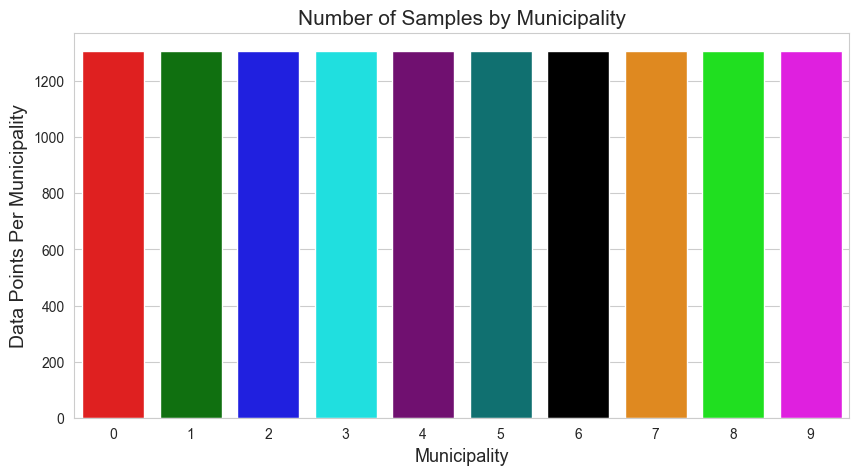

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of Data Points in Municipality-0: 1307 ~ 10.0%
Number of Data Points in Municipality-1: 1307 ~ 10.0%
Number of Data Points in Municipality-2: 1307 ~ 10.0%
Number of Data Points in Municipality-3: 1307 ~ 10.0%
Number of Data Points in Municipality-4: 1307 ~ 10.0%
Number of Data Points in Municipality-5: 1307 ~ 10.0%
Number of Data Points in Municipality-6: 1307 ~ 10.0%
Number of Data Points in Municipality-7: 1307 ~ 10.0%
Number of Data Points in Municipality-8: 1307 ~ 10.0%
Number of Data Points in Municipality-9: 1307 ~ 10.0%
------------------------------------------------------
Total Datapoints in All Municipalities: 13070 ~ 100.0%


In [7]:
# Analysis of Sample Counts in the Dataset

count_dict = dict(df['municipality_id'].value_counts())
myKeys = list(count_dict.keys())
myKeys.sort()
count_dict = {i: count_dict[i] for i in myKeys}

print()
size = 5
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(2 * size, size))
clr = ["red", "green", "blue", "cyan", "purple", "teal", "black", "darkorange", "lime", "magenta"]
sns.barplot(x=list(count_dict.keys()), y=list(count_dict.values()), ax=ax, palette=clr)
plt.xlabel('Municipality', fontsize=13)
plt.ylabel('Data Points Per Municipality', fontsize=14)
plt.title('Number of Samples by Municipality', fontsize=15)
plt.show()

print("- " * 54)
sum_percent = 0
for i in count_dict.keys():
    percent = round((count_dict[i] * 100) / sum(count_dict.values()), 2)
    sum_percent += percent
    print("Number of Data Points in Municipality-{0}: {1} ~ {2}%".format(i,
                                                                         count_dict[i],
                                                                         percent))

print("-" * 54)
print("Total Datapoints in All Municipalities: {0} ~ {1}%".format(sum(count_dict.values()),
                                                                  sum_percent))

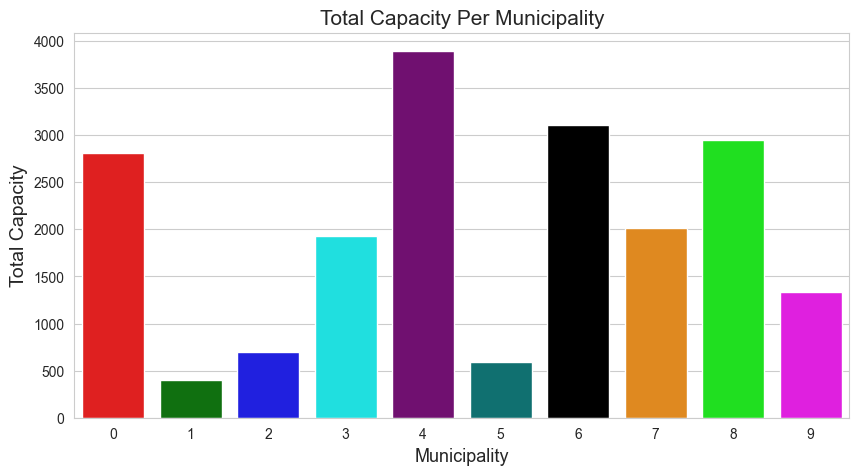

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Total Capacity of Municipality-0: 2813 ~ 14.26%
Total Capacity of Municipality-1: 397 ~ 2.01%
Total Capacity of Municipality-2: 697 ~ 3.53%
Total Capacity of Municipality-3: 1930 ~ 9.78%
Total Capacity of Municipality-4: 3893 ~ 19.73%
Total Capacity of Municipality-5: 587 ~ 2.98%
Total Capacity of Municipality-6: 3113 ~ 15.78%
Total Capacity of Municipality-7: 2019 ~ 10.23%
Total Capacity of Municipality-8: 2947 ~ 14.94%
Total Capacity of Municipality-9: 1332 ~ 6.75%
------------------------------------------------------
Total Capacity of All Municipalities: 19728 ~ 99.99%


In [8]:
# Percentage-Wise Distribution of Total Capacities

print()
size = 5
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(2 * size, size))
clr = ["red", "green", "blue", "cyan", "purple", "teal", "black", "darkorange", "lime", "magenta"]
sns.barplot(x=df["municipality_id"], y=df["total_capacity"], ax=ax, palette=clr)
plt.xlabel('Municipality', fontsize=13)
plt.ylabel('Total Capacity', fontsize=14)
plt.title('Total Capacity Per Municipality', fontsize=15)
plt.show()

print("- " * 54)
capacities = df[["municipality_id", "total_capacity"]].drop_duplicates().sort_values("municipality_id")
sum_percent = 0
for i in capacities.iterrows():
    percent = round((i[1]["total_capacity"] * 100) / sum(capacities["total_capacity"]), 2)
    sum_percent += percent
    print("Total Capacity of Municipality-{0}: {1} ~ {2}%".format(i[1]["municipality_id"],
                                                                      i[1]["total_capacity"],
                                                                      percent))

print("-" * 54)
print("Total Capacity of All Municipalities: {0} ~ {1}%".format(sum(capacities["total_capacity"]),
                                          sum_percent))

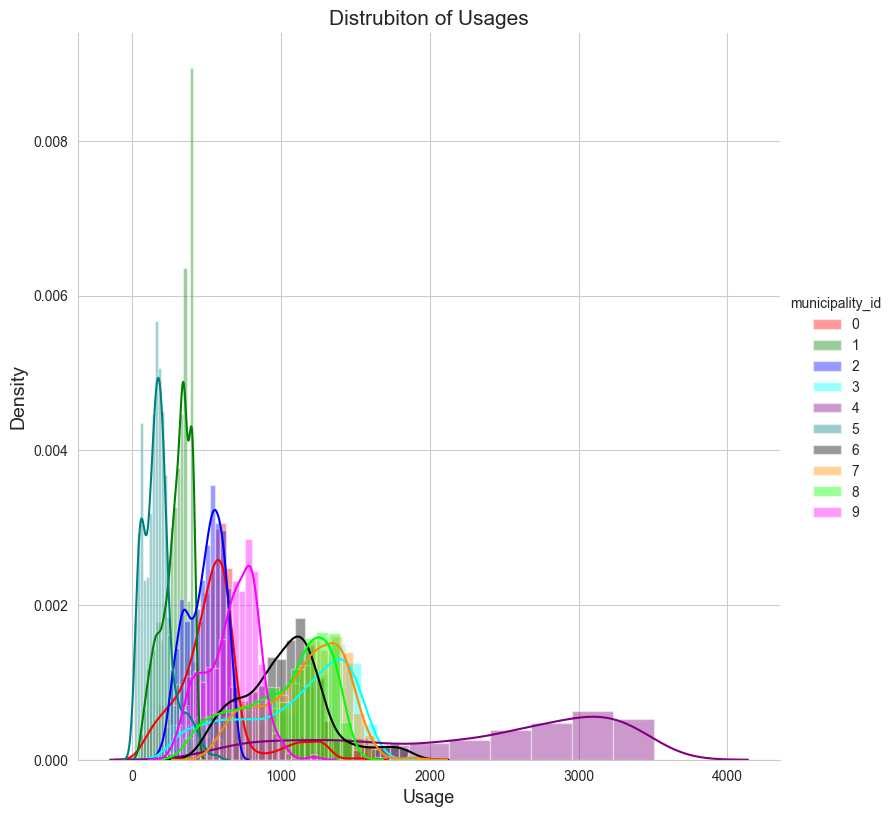

In [9]:
# Analysis of Usages

print()
sns.set_style("whitegrid")
clr = ["red", "green", "blue", "cyan", "purple", "teal", "black", "darkorange", "lime", "magenta"]
sns.FacetGrid(df, hue='municipality_id', height=8, palette=clr).map(sns.distplot, 'usage').add_legend()
plt.xlabel('Usage', fontsize=13)
plt.ylabel('Density', fontsize=14)
plt.title('Distrubiton of Usages', fontsize=15)
plt.show()

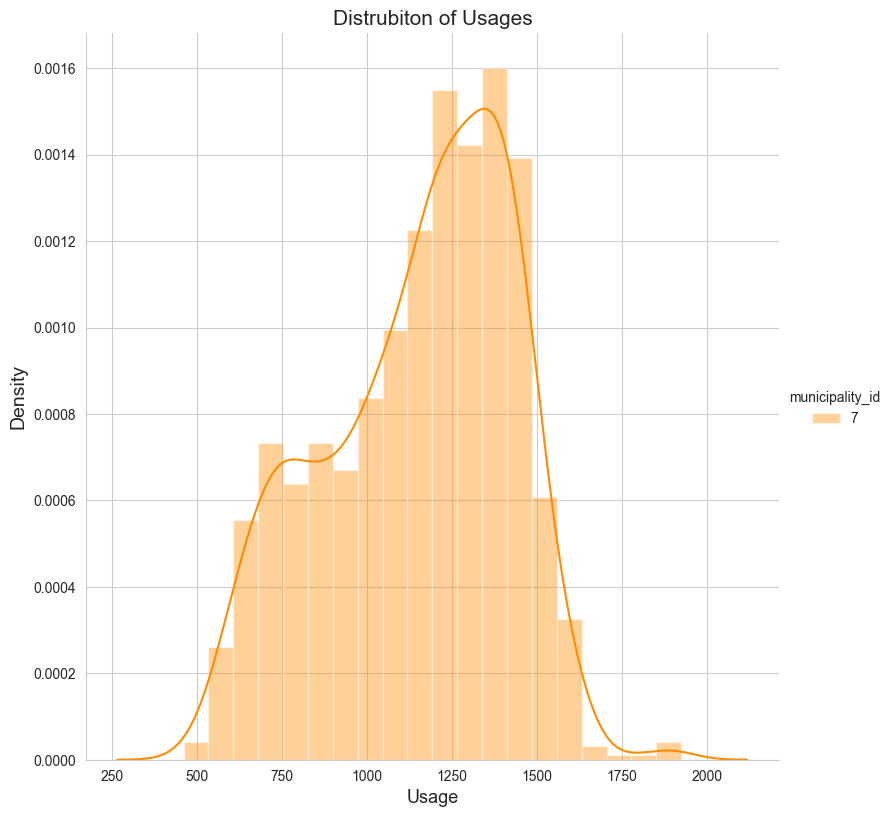

In [10]:
# Distribution of Usages for A Specific Municipality

m = 7
print()
sns.set_style("whitegrid")
clr = ["red", "green", "blue", "cyan", "purple", "teal", "black", "darkorange", "lime", "magenta"]
sns.FacetGrid(df[df.municipality_id == m], hue='municipality_id', height=8).map(sns.distplot, 'usage', color=clr[m]).add_legend()
plt.xlabel('Usage', fontsize=13)
plt.ylabel('Density', fontsize=14)
plt.title('Distrubiton of Usages', fontsize=15)
plt.show()

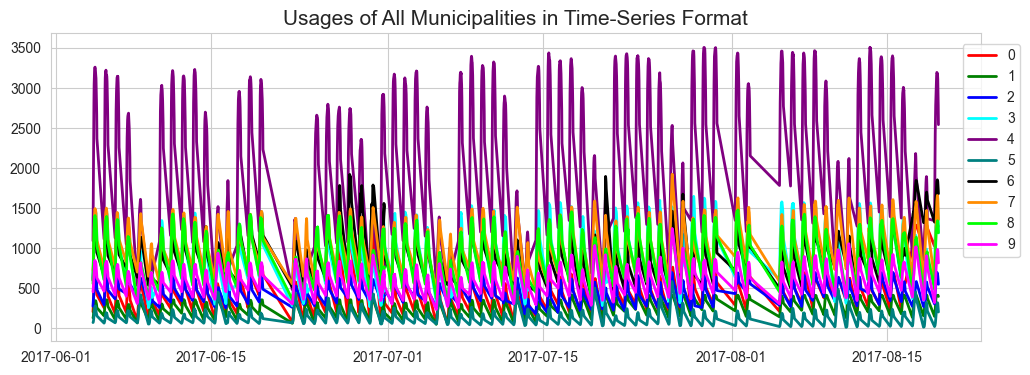

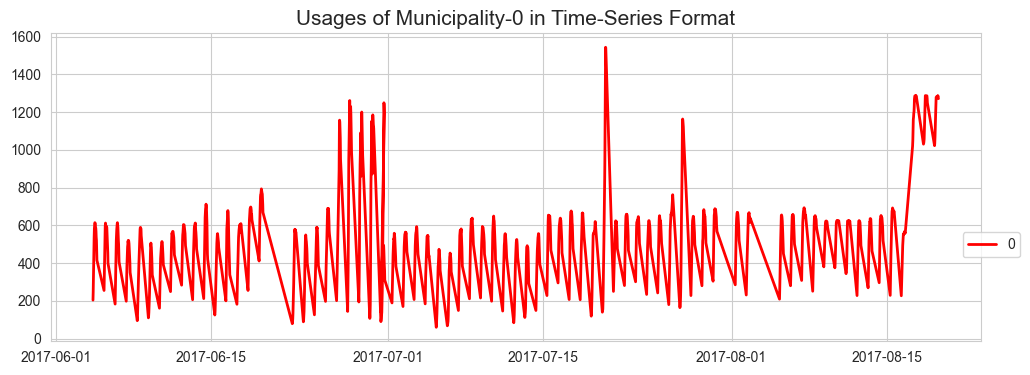

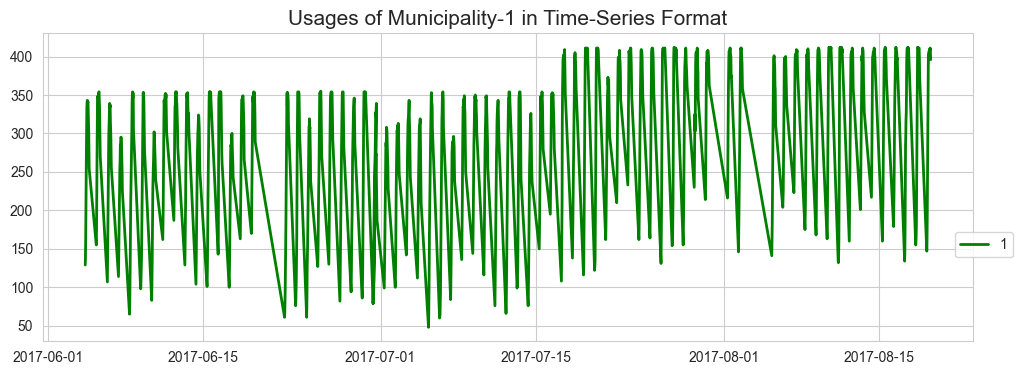

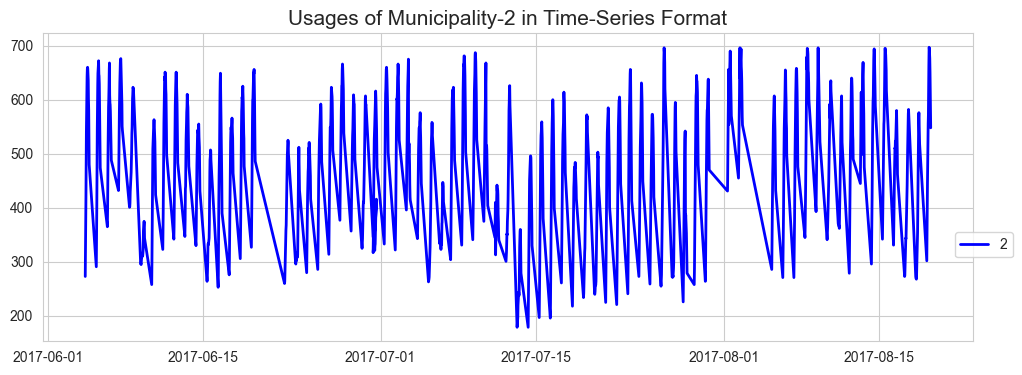

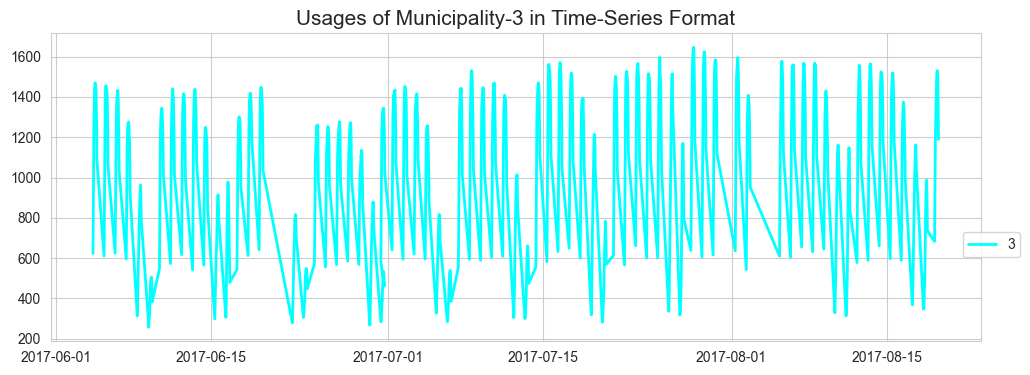

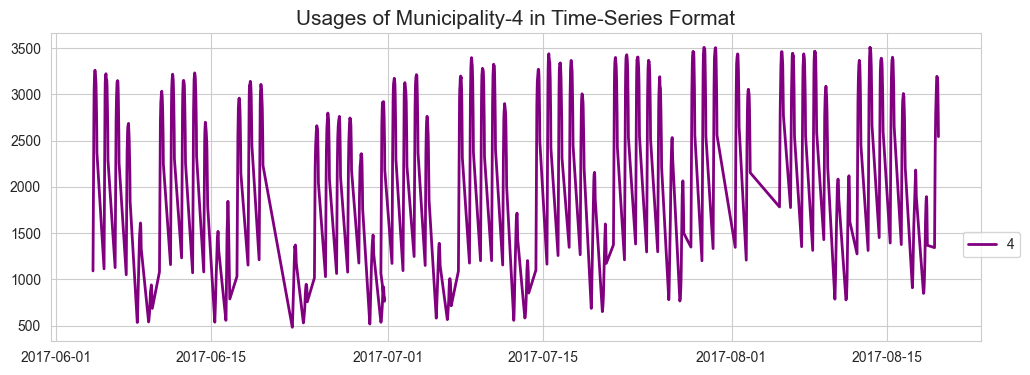

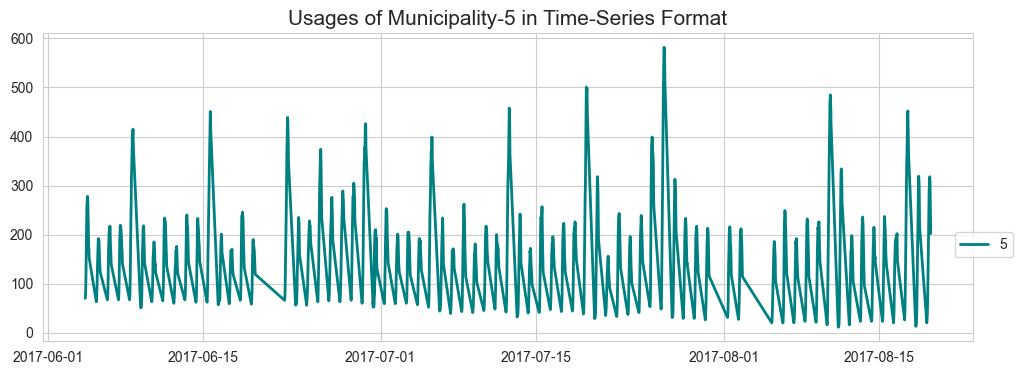

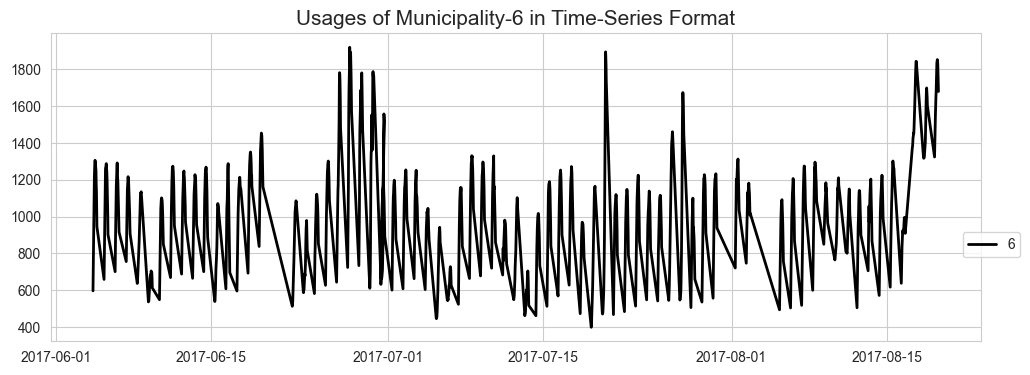

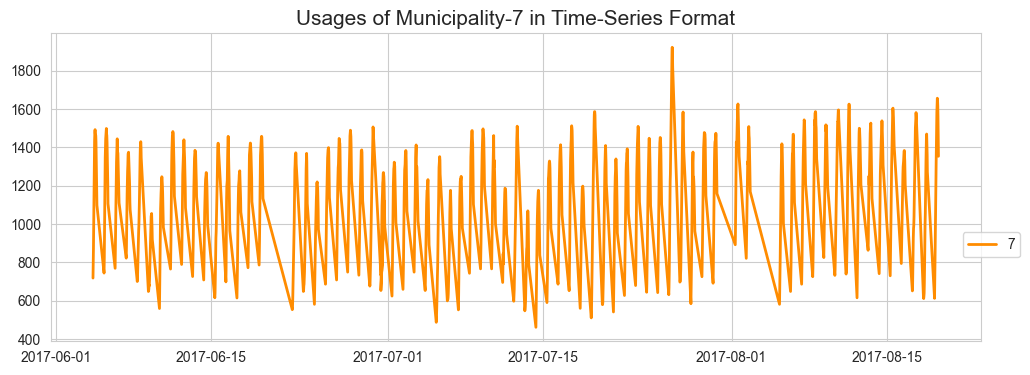

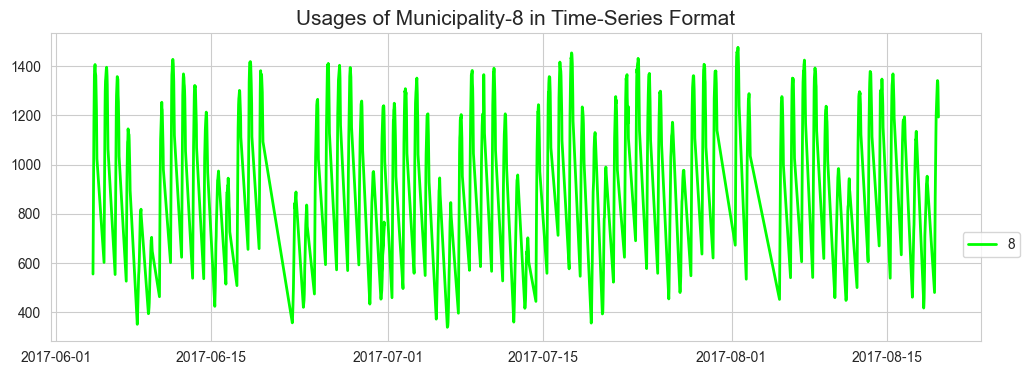

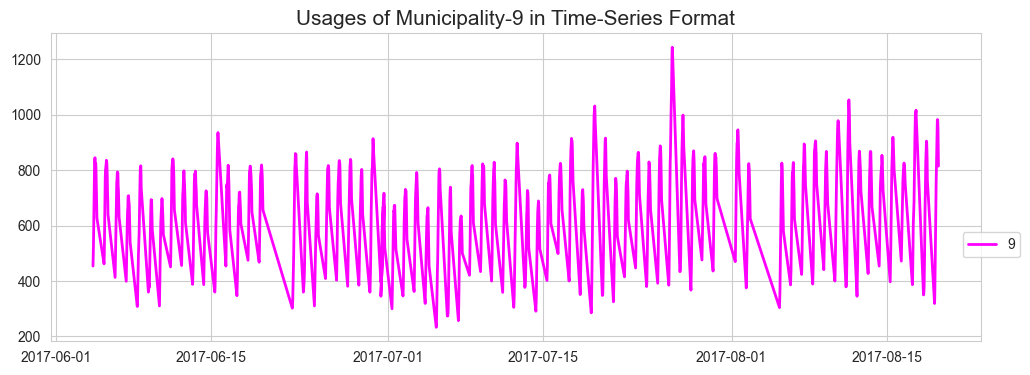

In [11]:
# Usages in Time-Series

print()
size = 4
plt.figure(figsize=(3 * size, 1 * size))
sns.set_style("whitegrid")
plt.rc('lines', linewidth=2)
clr = ["red", "green", "blue", "cyan", "purple", "teal", "black", "darkorange", "lime", "magenta"]

# Plot Usages Together
for i in range(10):
    plt.plot(df[df['municipality_id'] == i][["timestamp"]], df[df['municipality_id'] == i][['usage']].reset_index(drop=True), label=i, color=clr[i])

plt.legend(loc='lower right', bbox_to_anchor=(1.05, 0.25))
plt.title('Usages of All Municipalities in Time-Series Format', fontsize=15)
plt.show()
print("".center(55, "="))


# Plot Usages Separately
for i in range(10):
    size = 4
    plt.figure(figsize=(3 * size, 1 * size))
    sns.set_style("whitegrid")
    plt.rc('lines', linewidth=2)
    plt.plot(df[df['municipality_id'] == i][["timestamp"]], df[df['municipality_id'] == i][['usage']].reset_index(drop=True), label=i, color=clr[i])
    plt.legend(loc='lower right', bbox_to_anchor=(1.05, 0.25))
    plt.title(f'Usages of Municipality-{i} in Time-Series Format', fontsize=15)
    plt.show()
    print("".center(55, "="))

In [12]:
# Checking the Sections of the Dataframe Which does Not Have "hour" and "date" Sections

df

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


In [13]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [14]:
# Printing Detailed Information of the Dataframe After Grouping the Data by "municipality_id", "date" and "hour"

df = df.groupby(["municipality_id", "timestamp"])[["usage"]].max().reset_index()
check_df(df)

############################ DATA SHAPE ############################

(13070, 3)

############################ DATA TYPE #############################

municipality_id             int64
timestamp          datetime64[ns]
usage                       int64
dtype: object

########################### HEAD OF DATA ###########################


,municipality_id,timestamp,usage
0,0,2017-06-04 07:59:42,204
1,0,2017-06-04 08:25:42,247
2,0,2017-06-04 08:59:42,332
3,0,2017-06-04 09:32:46,429
4,0,2017-06-04 09:59:48,485



########################### TAIL OF DATA ###########################


,municipality_id,timestamp,usage
13065,9,2017-08-19 14:30:33,983
13066,9,2017-08-19 15:03:34,976
13067,9,2017-08-19 15:29:33,954
13068,9,2017-08-19 16:03:35,879
13069,9,2017-08-19 16:30:35,815



############################ DATA INFO #############################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   municipality_id  13070 non-null  int64         
 1   timestamp        13070 non-null  datetime64[ns]
 2   usage            13070 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 306.5 KB
None

############################ NULL DATA #############################

municipality_id    0
timestamp          0
usage              0
dtype: int64

########################## DESCRIBE DATA ###########################


,count,mean,min,25%,50%,75%,max,std
municipality_id,13070.0,4.5,0.0,2.0,4.5,7.0,9.0,2.872391
timestamp,13070,2017-07-12 00:30:03.819816448,2017-06-04 07:59:42,2017-06-24 09:03:01,2017-07-11 12:00:21,2017-07-29 14:28:36,2017-08-19 16:30:35,NaN
usage,13070.0,876.002984,11.0,403.0,692.0,1190.0,3508.0,679.287109



######################## QUANTILES OF DATA #########################


,count,mean,min,0%,5%,25%,50%,75%,95%,99%,max,std
municipality_id,13070.0,4.5,0.0,0.0,0.0,2.0,4.5,7.0,9.0,9.0,9.0,2.872391
timestamp,13070,2017-07-12 00:30:03.819816448,2017-06-04 07:59:42,2017-06-04 07:59:42,2017-06-07 13:30:29,2017-06-24 09:03:01,2017-07-11 12:00:21,2017-07-29 14:28:36,2017-08-16 11:03:08,2017-08-19 09:56:32,2017-08-19 16:30:35,NaN
usage,13070.0,876.002984,11.0,11.0,141.0,403.0,692.0,1190.0,2558.55,3318.31,3508.0,679.287109


In [15]:
# Training the Models and Plotting the Results

In [16]:
# Splitting Train Set and Test Set

train = df.loc[pd.to_datetime(df["timestamp"]) < pd.Timestamp("2017-08-05"), :]
test = df.loc[pd.to_datetime(df["timestamp"]) >= pd.Timestamp("2017-08-05"), :]

print(f"Shape of the Dataframe: {df.shape}")
print(f"Shape of the Train Set: {train.shape}")
print(f"Shape of the Test Set:  {test.shape}")

Shape of the Dataframe: (13070, 3)
Shape of the Train Set: (10390, 3)
Shape of the Test Set:  (2680, 3)


In [17]:
# Creating Dictionaries of train_sets and test_sets

train_sets = dict()
test_sets = dict()
for i in range(df.municipality_id.nunique()):
    train_sets[f"train{i}"] = train.loc[train.municipality_id == i]
    test_sets[f"test{i}"] = test.loc[test.municipality_id == i]

In [18]:
# Defining A Function to Plot Scores of the Trained Models

def plot_scores(before, after, title=""):
    size = 5
    width = 0.4
    length = len(before)
    x = np.arange(length)
    labels = range(length)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(2 * size, size))
    
    ax.bar(x - width / 2, before, width, label='Before')
    ax.bar(x + width / 2, after, width, label='After')

    ax.set_ylabel("RMSE Scores", fontsize=13)
    ax.set_xlabel("Municipality", fontsize=14)
    ax.set_title(f"{title}: Before / After Tuning (Lower is Better)", fontsize=15)
    ax.set_xticks(labels)
    fig.tight_layout()
    ax.legend()
    plt.show()

In [19]:
# 1. TES Model

rmse_scores_tes = []
mae_scores_tes = []


def tes_base(train, test):
    global rmse_scores_tes, mae_scores_tes
    tes_model = ExponentialSmoothing(train_sets[train]["usage"],
                                     trend="add",
                                     seasonal="add",
                                     seasonal_periods=7).fit(smoothing_level=0.5,
                                                             smoothing_slope=0.5,
                                                             smoothing_seasonal=0.5)
    y_pred = tes_model.forecast(len(test_sets[test]))
    print(f"Results for {train[-1]}. Municipality")
    rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
    rmse_scores_tes.append(rmse)
    print(f"RMSE: {rmse}")

    mae = mean_absolute_error(test_sets[test]['usage'], y_pred)
    mae_scores_tes.append(mae)
    print(f"MAE:  {mae}")
    print("".center(50, "="))

In [20]:
# Training the TES Model and Printing Average RMSE & Average MAE Scores

for tr, te in zip(train_sets.keys(), test_sets.keys()):
    tes_base(tr, te)

print(f"Average RMSE: {np.mean(rmse_scores_tes)}")
print(f"Average MAE:  {np.mean(mae_scores_tes)}")

Results for 0. Municipality
RMSE: 4677.205078762797
MAE:  3993.441429105801
Results for 1. Municipality
RMSE: 3963.1338360747036
MAE:  3434.0153331740034
Results for 2. Municipality
RMSE: 6431.927801757307
MAE:  5587.197845386946
Results for 3. Municipality
RMSE: 29700.880785128196
MAE:  25845.128629507097
Results for 4. Municipality
RMSE: 56595.789602914796
MAE:  49264.44656880732
Results for 5. Municipality
RMSE: 5169.937755413505
MAE:  4487.7769769943725
Results for 6. Municipality
RMSE: 11690.547762135682
MAE:  10107.109670182826
Results for 7. Municipality
RMSE: 21417.936206990064
MAE:  18602.84555219916
Results for 8. Municipality
RMSE: 19414.008368357496
MAE:  16857.1555630213
Results for 9. Municipality
RMSE: 14986.444900541297
MAE:  13015.647700028654
Average RMSE: 17404.781209807585
Average MAE:  15119.476526840746


In [21]:
# 1. TES Model Hyperparameter Tuning

def tes_objective(trial, train, test):
    try:
        alpha = trial.suggest_float("alpha", 0.2, 1)
        beta = trial.suggest_float("beta", 0.2, 1)
        gamma = trial.suggest_float("gamma", 0.2, 1)
        tes_model = ExponentialSmoothing(train_sets[train]["usage"],
                                         trend="add",
                                         seasonal="add",
                                         seasonal_periods=7).fit(smoothing_level=alpha,
                                                                 smoothing_slope=beta,
                                                                 smoothing_seasonal=gamma)
        y_pred = tes_model.forecast(len(test_sets[test]))
        rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
        return rmse
    except:
        pass

In [22]:
# Training the TES Model After Hyperparameter Tuning

rmse_scores_tes_tuned = []
model_tes_params = dict()

for tr, te in zip(train_sets.keys(), test_sets.keys()):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)

    study_tes = optuna.create_study(direction="minimize")
    print(f"Process started for {tr[-1]}. Municipality")

    study_tes.optimize(lambda trial: tes_objective(trial, tr, te), n_trials=500, n_jobs=-1)
    print(f"Best RMSE score for {tr[-1]}: {study_tes.best_value}")
    print(f"Best parameters for {tr[-1]}: {study_tes.best_params}")

    rmse_scores_tes_tuned.append(study_tes.best_value)
    model_tes_params[f"model{tr[-1]}"] = study_tes.best_params
    print("".center(50, "="))

Process started for 0. Municipality
Best RMSE score for 0: 258.34539487452827
Best parameters for 0: {'alpha': 0.9174780787649585, 'beta': 0.23547930680999687, 'gamma': 0.20086904029286007}
Process started for 1. Municipality
Best RMSE score for 1: 88.19706879793164
Best parameters for 1: {'alpha': 0.2523349042524431, 'beta': 0.22154531829334273, 'gamma': 0.65362869691786}
Process started for 2. Municipality
Best RMSE score for 2: 130.66856350193015
Best parameters for 2: {'alpha': 0.9063710061167237, 'beta': 0.22659583122319205, 'gamma': 0.4022700547892431}
Process started for 3. Municipality
Best RMSE score for 3: 381.3244251210542
Best parameters for 3: {'alpha': 0.29728839901172316, 'beta': 0.28735503297014997, 'gamma': 0.8474811732216082}
Process started for 4. Municipality
Best RMSE score for 4: 830.2378350749306
Best parameters for 4: {'alpha': 0.2735175119492545, 'beta': 0.4351678518483843, 'gamma': 0.71859815511401}
Process started for 5. Municipality
Best RMSE score for 5: 11

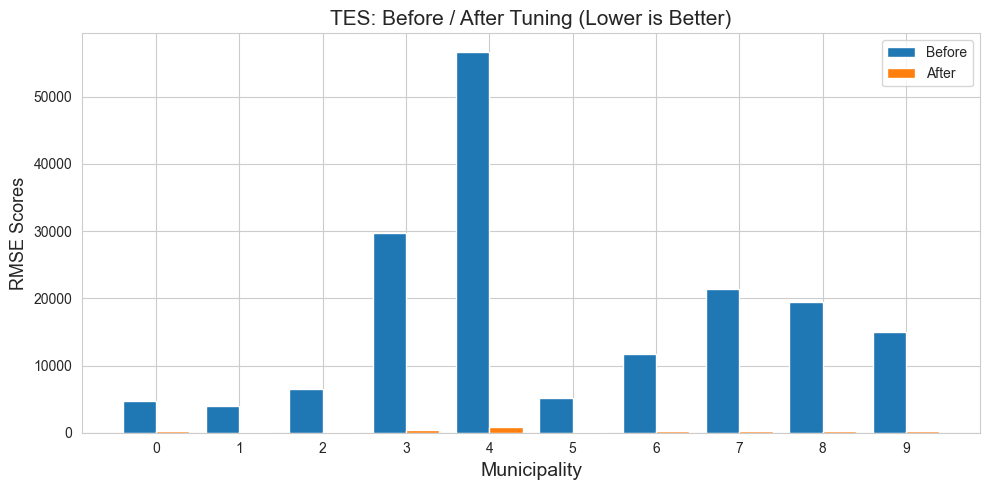

In [23]:
# Plotting Results of the TES Model Before and After Tuning

plot_scores(rmse_scores_tes, rmse_scores_tes_tuned, "TES")

In [24]:
###################################################

In [25]:
# 2. SARIMA Model

rmse_scores_sar = []
mae_scores_sar = []


def sarima_base(train, test):
    global rmse_scores_sar, mae_scores_sar
    model = SARIMAX(train_sets[train]["usage"], order=(1, 0, 1), seasonal_order=(0, 0, 0, 7))
    sarima_model = model.fit(disp=0)
    y_pred_test = sarima_model.get_forecast(steps=len(test_sets[test]))
    y_pred = y_pred_test.predicted_mean

    print(f"Results for {train[-1]}. Municipality")
    rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
    rmse_scores_sar.append(rmse)
    print(f"RMSE: {rmse}")

    mae = mean_absolute_error(test_sets[test]['usage'], y_pred)
    mae_scores_sar.append(mae)
    print(f"MAE:  {mae}")
    print("".center(50, "="))

In [26]:
# Training the SARIMA Model and Printing Average RMSE & Average MAE Scores

for tr, te in zip(train_sets.keys(), test_sets.keys()):
    sarima_base(tr, te)

print(f"Average RMSE: {np.mean(rmse_scores_sar)}")
print(f"Average MAE:  {np.mean(mae_scores_sar)}")

Results for 0. Municipality
RMSE: 689.3912471814394
MAE:  597.4055290200178
Results for 1. Municipality
RMSE: 294.71791906362324
MAE:  272.0249133692784
Results for 2. Municipality
RMSE: 336.6559105575369
MAE:  300.9968083260739
Results for 3. Municipality
RMSE: 933.391236188214
MAE:  854.4520634904426
Results for 4. Municipality
RMSE: 2048.2983607745937
MAE:  1870.9609079051281
Results for 5. Municipality
RMSE: 191.2912006610169
MAE:  157.15784837956159
Results for 6. Municipality
RMSE: 895.8329096942927
MAE:  780.0279180513129
Results for 7. Municipality
RMSE: 890.3875391919779
MAE:  806.2066083872459
Results for 8. Municipality
RMSE: 774.3484048767049
MAE:  702.0479240025122
Results for 9. Municipality
RMSE: 573.891168291358
MAE:  522.57404804985
Average RMSE: 762.8205896480757
Average MAE:  686.3854568981424


In [27]:
# 2. SARIMA Model Hyperparameter Tuning

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]


def sarima_optimizer(train, test, pdq, seasonal_pdq):
    best_rmse, best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train_sets[train]["usage"], order=param, seasonal_order=param_seasonal).fit(disp=0)
                y_pred_test = model.get_forecast(steps=len(test_sets[test]))
                y_pred = y_pred_test.predicted_mean
                rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
                if rmse < best_rmse:
                    best_rmse, best_order, best_seasonal_order = rmse, param, param_seasonal
                    best_mae = mean_absolute_error(test, y_pred)
            except:
                continue

    print(f"Results for {tr[-1]}. Municipality")
    print(f"SARIMA: {best_order} x {best_seasonal_order}")
    print(f"Best RMSE: {best_rmse}")
    print("".center(50, "="))

    return best_order, best_seasonal_order, best_rmse, best_mae

In [28]:
# Training the SARIMA Model After Hyperparameter Tuning

rmse_scores_sar_tuned = []
model_sar_params = dict()

for tr, te in zip(train_sets.keys(), test_sets.keys()):
    best_order, best_seasonal_order, best_rmse, best_mae = sarima_optimizer(tr, te, pdq, seasonal_pdq)
    rmse_scores_sar_tuned.append(best_rmse)
    model_sar_params[f"model{tr[-1]}"] = best_order, best_seasonal_order

Results for 0. Municipality
SARIMA: (0, 1, 0) x (0, 1, 1, 7)
Best RMSE: 270.5602454707188
Results for 1. Municipality
SARIMA: (0, 0, 0) x (1, 1, 1, 7)
Best RMSE: 84.05448112682069
Results for 2. Municipality
SARIMA: (0, 0, 0) x (1, 0, 1, 7)
Best RMSE: 118.91782147589468
Results for 3. Municipality
SARIMA: (0, 0, 0) x (1, 1, 1, 7)
Best RMSE: 354.03268723479107
Results for 4. Municipality
SARIMA: (0, 1, 1) x (1, 0, 1, 7)
Best RMSE: 806.0702876141737
Results for 5. Municipality
SARIMA: (1, 0, 0) x (0, 1, 1, 7)
Best RMSE: 106.0834910310697
Results for 6. Municipality
SARIMA: (1, 1, 1) x (0, 1, 1, 7)
Best RMSE: 282.90092196580497
Results for 7. Municipality
SARIMA: (0, 0, 0) x (1, 1, 1, 7)
Best RMSE: 282.5754400406435
Results for 8. Municipality
SARIMA: (0, 1, 0) x (0, 0, 0, 7)
Best RMSE: 276.5335733038198
Results for 9. Municipality
SARIMA: (1, 1, 1) x (1, 1, 1, 7)
Best RMSE: 179.16714065196328


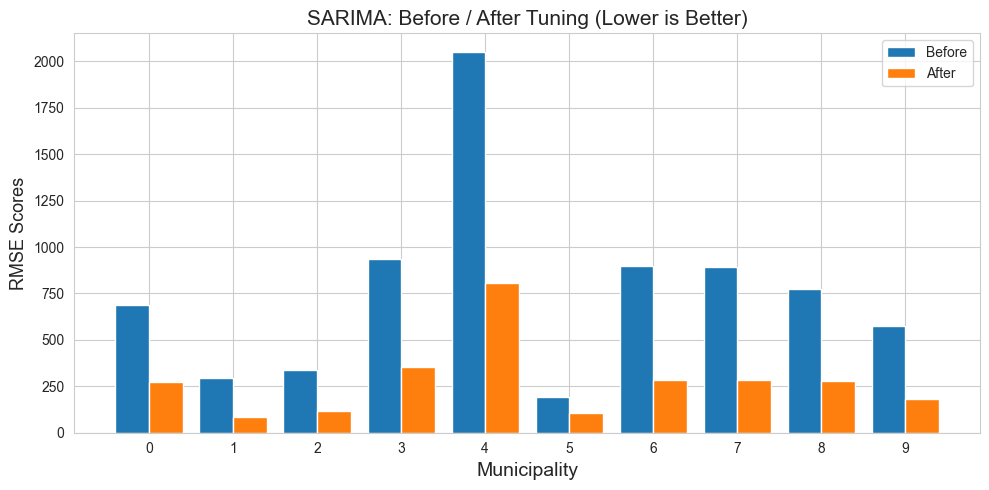

In [29]:
# Plotting Results of the SARIMA Model Before and After Tuning

plot_scores(rmse_scores_sar, rmse_scores_sar_tuned, "SARIMA")

In [30]:
###################################################

In [31]:
# 3. LGBM Model

rmse_scores_lgb = []
mae_scores_lgb = []


def lgbm_base(train, test):
    global rmse_scores_lgb, mae_scores_lgb
    params = LGBMRegressor().get_params()
    del params["importance_type"]
    params["verbosity"] = -99

    lgb_train = lgb.Dataset(train_sets[train].drop("timestamp", axis=1), label=train_sets[train]["usage"])
    lgb_val = lgb.Dataset(test_sets[test].drop("timestamp", axis=1), label=test_sets[test]["usage"])
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val])
    y_pred = model.predict(test_sets[test].drop("timestamp", axis=1), num_iteration=model.best_iteration)

    print(f"Results for {train[-1]}. Municipality")
    rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
    rmse_scores_lgb.append(rmse)
    print(f"RMSE: {rmse}")

    mae = mean_absolute_error(test_sets[test]['usage'], y_pred)
    mae_scores_lgb.append(mae)
    print(f"MAE:  {mae}")
    print("".center(50, "="))

In [32]:
# Training the LGBM Model and Printing RMSE & MAE Scores

for tr, te in zip(train_sets.keys(), test_sets.keys()):
    lgbm_base(tr, te)

print(f"Average RMSE: {np.mean(rmse_scores_lgb)}")
print(f"Average MAE:  {np.mean(mae_scores_lgb)}")

Results for 0. Municipality
RMSE: 15.065181133859612
MAE:  5.677869678534923
Results for 1. Municipality
RMSE: 0.5277978076732922
MAE:  0.26440759141776876
Results for 2. Municipality
RMSE: 2.537363628533402
MAE:  1.013747901283427
Results for 3. Municipality
RMSE: 3.0301315015173382
MAE:  1.8767528777489582
Results for 4. Municipality
RMSE: 7.4137694811139765
MAE:  4.4371349304515695
Results for 5. Municipality
RMSE: 6.381588601087225
MAE:  2.347752664692851
Results for 6. Municipality
RMSE: 8.220372177943492
MAE:  3.1863641217275034
Results for 7. Municipality
RMSE: 30.909263638100665
MAE:  11.022529093047277
Results for 8. Municipality
RMSE: 2.1874379167906643
MAE:  1.4359291372401504
Results for 9. Municipality
RMSE: 20.06367665540633
MAE:  6.022536660718981
Average RMSE: 9.6336582542026
Average MAE:  3.7285024656863412


In [33]:
# 3. LGBM Model Hyperparameter Tuning

params = dict(
    max_depth=hp.randint("max_depth", 2, 15),
    early_stopping_rounds=hp.randint("early_stopping_rounds", 2, 350),
    feature_fraction=hp.uniform("feature_fraction", 0.5, 1),
    learning_rate=hp.uniform("learning_rate", 0.0001, 0.2),
    num_boost_round=hp.randint("num_boost_round", 50, 2500),
    num_leaves=hp.randint("num_leaves", 10, 100),
    n_jobs=-1,
    random_state=41,
    verbosity=-9999)


def lgbm_objective(params, train, test):
    lgb_train = lgb.Dataset(train_sets[train].drop("timestamp", axis=1), label=train_sets[train]["usage"])
    lgb_val = lgb.Dataset(test_sets[test].drop("timestamp", axis=1), label=test_sets[test]["usage"])
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val], num_boost_round=params['num_boost_round'])
    y_pred = model.predict(test_sets[test].drop("timestamp", axis=1), num_iteration=model.best_iteration)

    rmse = np.sqrt(mean_squared_error(test_sets[test]['usage'], y_pred))
    return rmse

In [34]:
# Training the LGBM Model After Hyperparameter Tuning

rmse_scores_lgbm_tuned = list()
model_lgbm_params = dict()
for tr, te in zip(train_sets.keys(), test_sets.keys()):
    print(f"Process started for {tr[-1]}. Municipality")
    trials = Trials()
    best = fmin(
        fn=lambda params: lgbm_objective(params, tr, te),
        space=params,
        algo=tpe.suggest,
        max_evals=200,
        trials=trials,
        verbose=False)

    best_rmse = trials.results[np.argmin([r['loss'] for r in trials.results])]['loss']
    print(f"Best RMSE score for {tr[-1]}. Municipality: {best_rmse}")
    print(f"Best parameters for {tr[-1]}: {best}")
    
    rmse_scores_lgbm_tuned.append(best_rmse)
    model_lgbm_params[f"model{tr[-1]}"] = best
    print("".center(50, "="))

Process started for 0. Municipality
Best RMSE score for 0. Municipality: 15.057417095889052
Best parameters for 0: {'early_stopping_rounds': 214, 'feature_fraction': 0.589543982761566, 'learning_rate': 0.07592747044800147, 'max_depth': 5, 'num_boost_round': 1255, 'num_leaves': 63}
Process started for 1. Municipality
Best RMSE score for 1. Municipality: 0.5050578551833375
Best parameters for 1: {'early_stopping_rounds': 287, 'feature_fraction': 0.8132931904000266, 'learning_rate': 0.10915714693940992, 'max_depth': 13, 'num_boost_round': 2301, 'num_leaves': 49}
Process started for 2. Municipality
Best RMSE score for 2. Municipality: 2.5302930562441843
Best parameters for 2: {'early_stopping_rounds': 57, 'feature_fraction': 0.8326326345967004, 'learning_rate': 0.0771823795798921, 'max_depth': 11, 'num_boost_round': 1450, 'num_leaves': 63}
Process started for 3. Municipality
Best RMSE score for 3. Municipality: 2.9780534585990415
Best parameters for 3: {'early_stopping_rounds': 285, 'featu

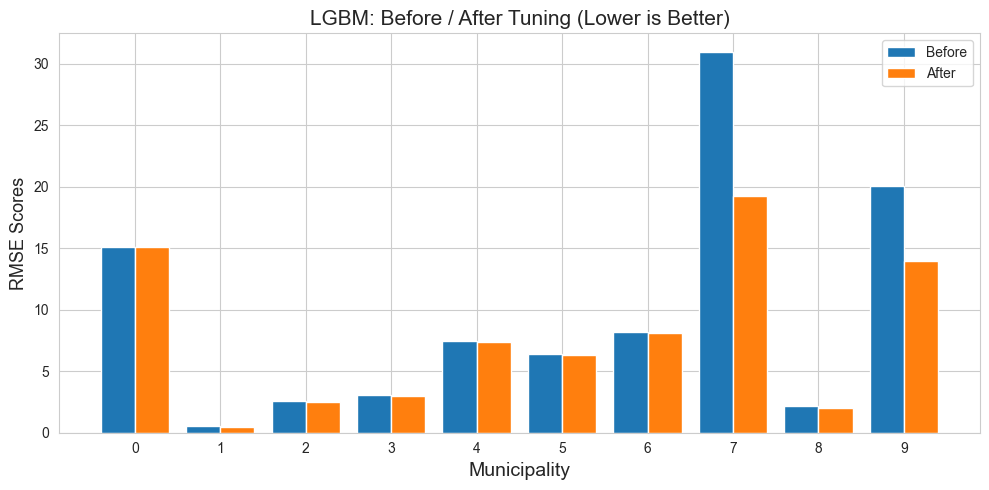

In [35]:
# Plotting Results of the LGBM Model Before and After Tuning

plot_scores(rmse_scores_lgb, rmse_scores_lgbm_tuned, "LGBM")

In [36]:
###################################################

In [37]:
# Defining A Function to Plot the Results from All the Models Together

def plot_final_scores(tes, sarima, lgbm, title=""):
    size = 5
    width = 0.4
    length = len(tes)
    x = np.arange(length)
    labels = range(length)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(2 * size, size))

    ax.bar(x - width / 3, tes, width, label='TES')
    ax.bar(x + width / 3, sarima, width, label='SARIMA')
    ax.bar(x + width * 2 / 3, lgbm, width, label='LGBM')

    ax.set_ylabel("RMSE Scores", fontsize=13)
    ax.set_xlabel("Municipality", fontsize=14)
    ax.set_title(f"{title} (Lower is Better)", fontsize=15)
    ax.set_xticks(labels)
    fig.tight_layout()
    ax.legend()
    plt.show()

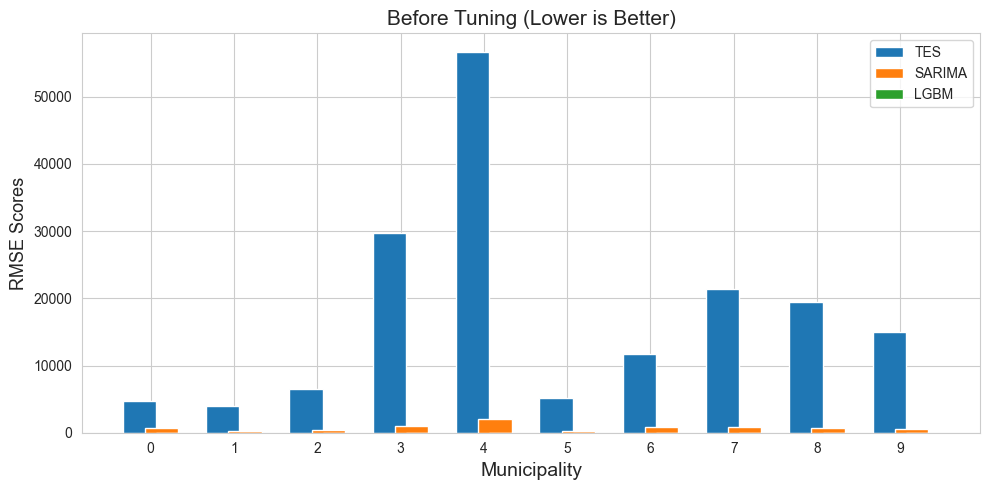

In [38]:
# Comparison of the Model Results without Tunings

plot_final_scores(rmse_scores_tes, rmse_scores_sar, rmse_scores_lgb, "Before Tuning")

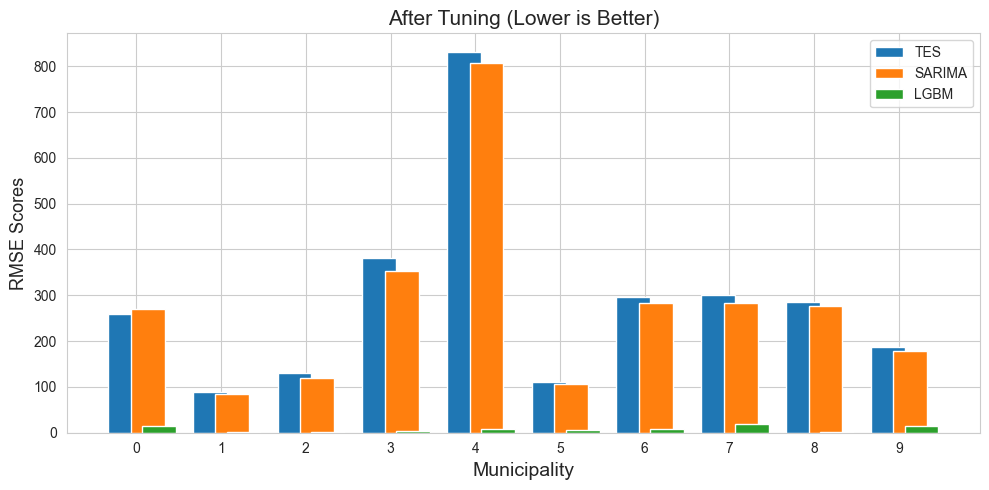

In [39]:
# Comparison of the Model Results with Tunings

plot_final_scores(rmse_scores_tes_tuned, rmse_scores_sar_tuned, rmse_scores_lgbm_tuned, "After Tuning")

In [40]:
# Defining A Function of the Final Model

def final_model(train, test, params):
    lgb_train = lgb.Dataset(train_sets[train].drop("timestamp", axis=1), label=train_sets[train]["usage"])
    lgb_val = lgb.Dataset(test_sets[test].drop("timestamp", axis=1), label=test_sets[test]["usage"])
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val], num_boost_round=params['num_boost_round'])

    all_test = test_sets[test].drop("timestamp", axis=1)
    first_week = all_test[:int(len(all_test) / 2)]
    last_week = all_test[int(len(all_test) / 2):]

    y_pred = model.predict(all_test, num_iteration=model.best_iteration)
    y_pred_first = model.predict(first_week, num_iteration=model.best_iteration)
    y_pred_last = model.predict(last_week, num_iteration=model.best_iteration)

    rmse_first = np.sqrt(mean_squared_error(test_sets[test]['usage'][:int(len(test_sets[test]) / 2)], y_pred_first))
    rmse_last = np.sqrt(mean_squared_error(test_sets[test]['usage'][int(len(test_sets[test]) / 2):], y_pred_last))

    print(f"\nFirst Week RMSE for {tr[-1]}. Municipality: {rmse_first}")
    print(f"Last  Week RMSE for {tr[-1]}. Municipality: {rmse_last}")

    return y_pred


First Week RMSE for 0. Municipality: 0.8940402010037907
Last  Week RMSE for 0. Municipality: 21.275627166270162


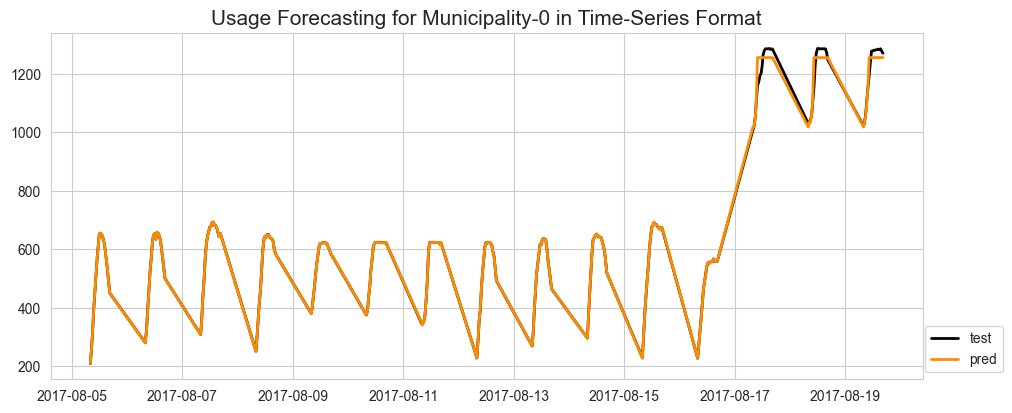


First Week RMSE for 1. Municipality: 0.5562577332327646
Last  Week RMSE for 1. Municipality: 0.44804487318072567


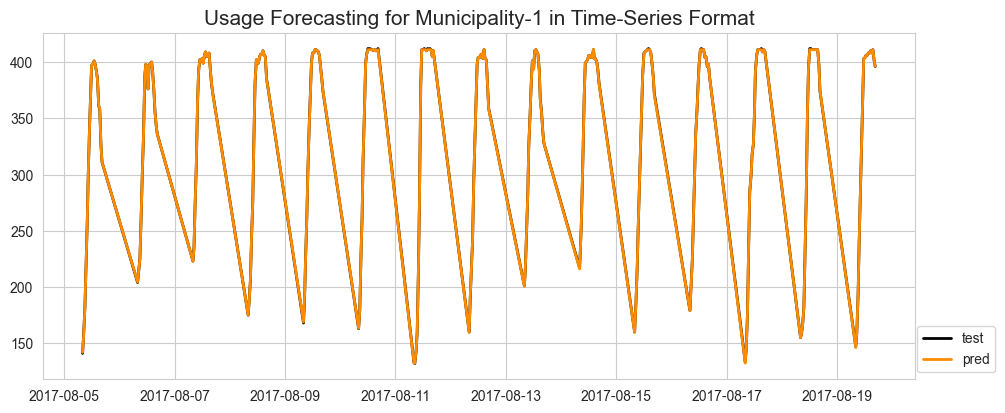


First Week RMSE for 2. Municipality: 2.1126628140610775
Last  Week RMSE for 2. Municipality: 2.888151958439618


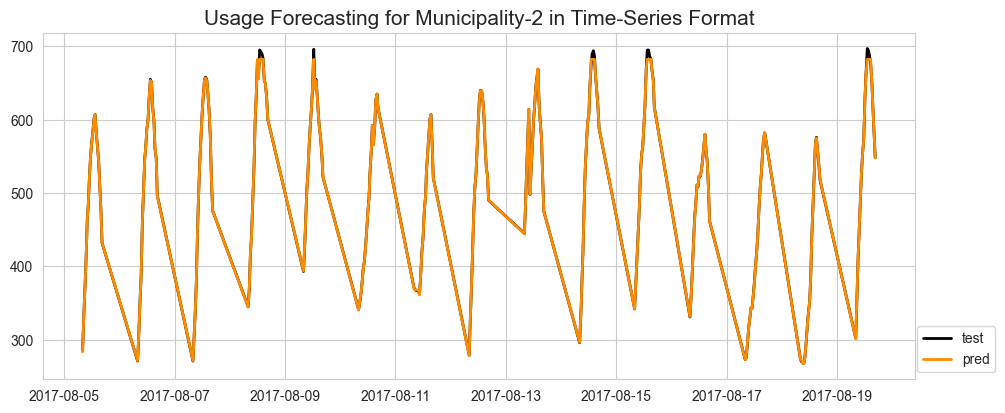


First Week RMSE for 3. Municipality: 3.455702984680377
Last  Week RMSE for 3. Municipality: 2.407430515345887


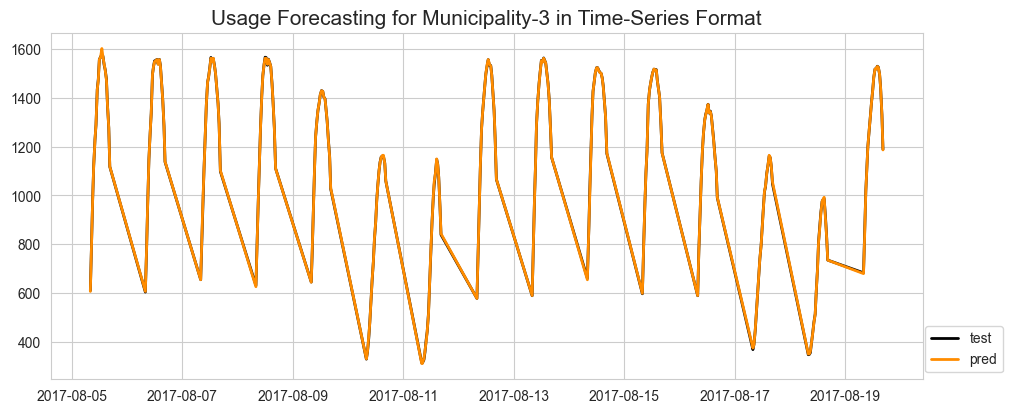


First Week RMSE for 4. Municipality: 7.4413014556088015
Last  Week RMSE for 4. Municipality: 7.253698890888505


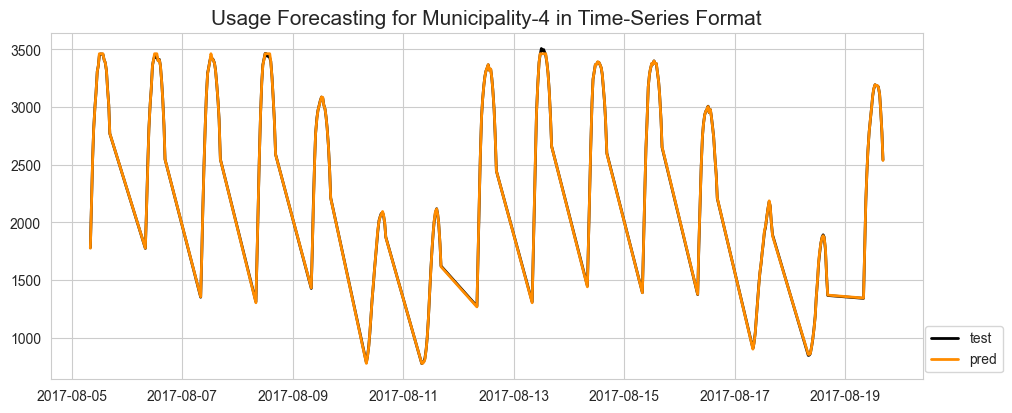


First Week RMSE for 5. Municipality: 6.497906704502788
Last  Week RMSE for 5. Municipality: 6.166078213155463


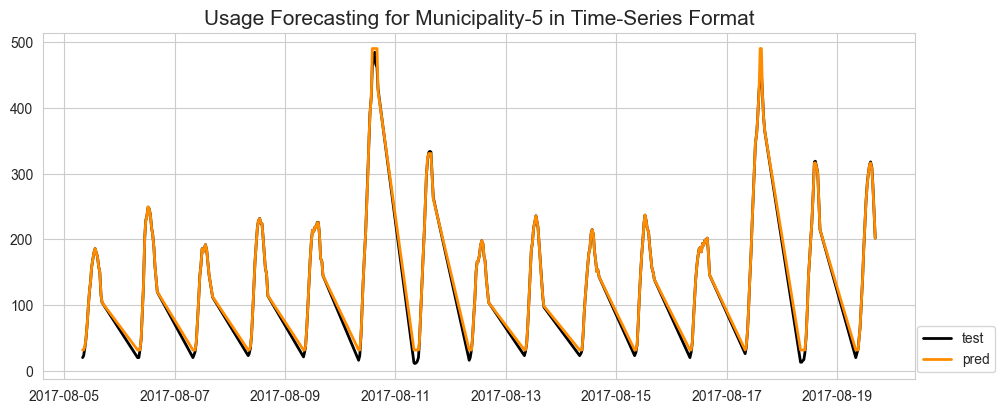


First Week RMSE for 6. Municipality: 1.977436328901143
Last  Week RMSE for 6. Municipality: 11.329370706455556


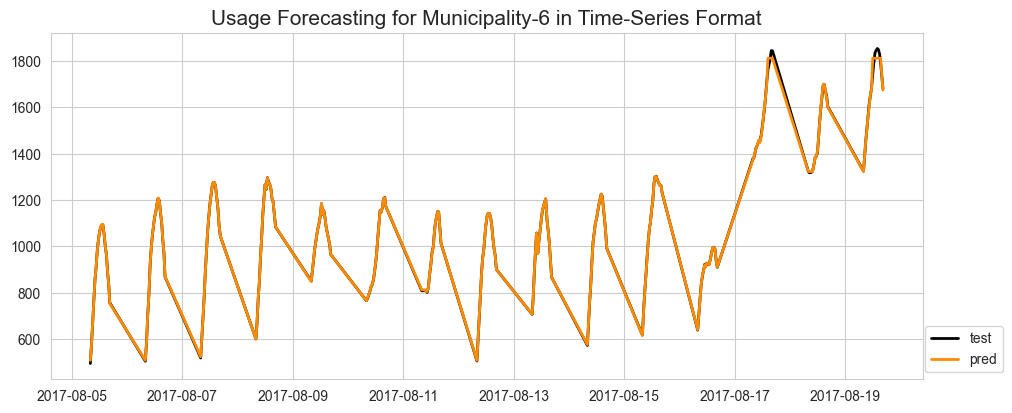


First Week RMSE for 7. Municipality: 20.13546583846166
Last  Week RMSE for 7. Municipality: 18.271026635225464


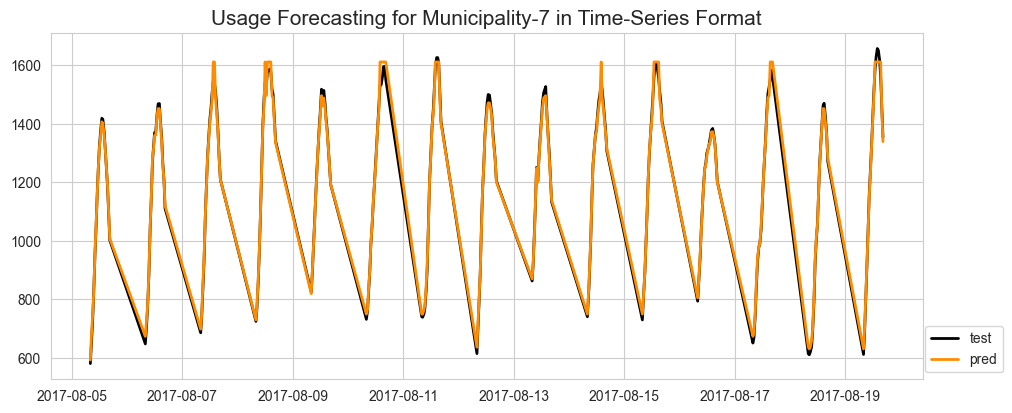


First Week RMSE for 8. Municipality: 2.2288222922950407
Last  Week RMSE for 8. Municipality: 1.7865237831480232


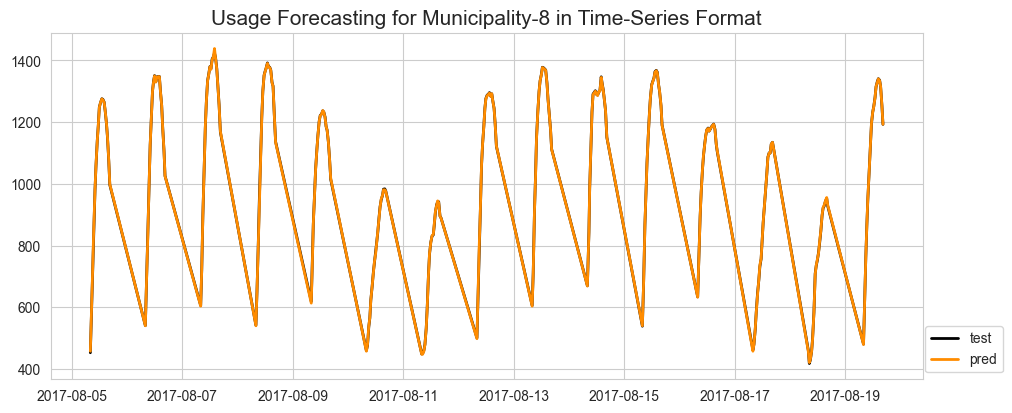


First Week RMSE for 9. Municipality: 14.72204111835236
Last  Week RMSE for 9. Municipality: 13.063455454629079


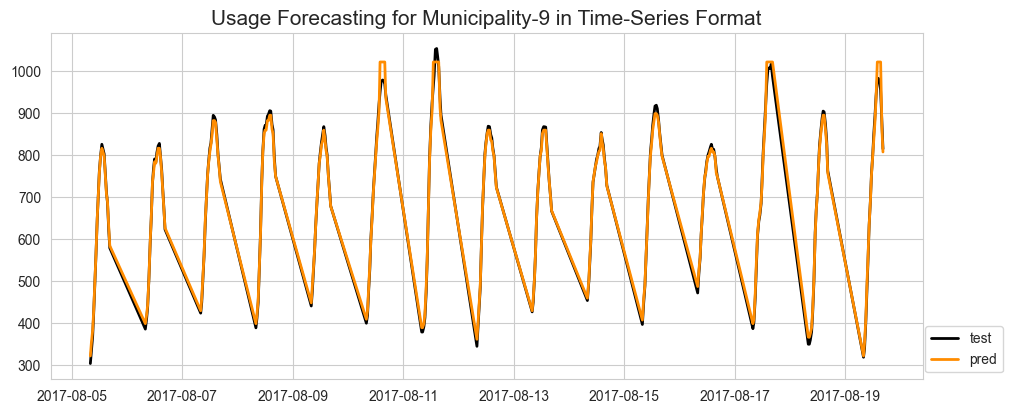

In [41]:
# Plotting Bus Usages in Time Series with the Predictions

for i, (tr, te) in enumerate(zip(train_sets.keys(), test_sets.keys())):
    params = model_lgbm_params[f"model{tr[-1]}"]
    params["verbosity"] = -999

    plot_tr = train_sets[tr]
    plot_tr.index = range(0, len(plot_tr))

    plot_te = test_sets[te]
    plot_te.index = range(len(plot_tr), len(plot_tr) + len(plot_te))

    y_pred = final_model(tr, te, params)
    y_pred = pd.DataFrame(y_pred)
    y_pred.index = range(len(plot_tr), len(plot_tr) + len(plot_te))

    size = 2.25
    plt.figure(figsize=(5 * size, 2 * size))
    sns.set_style("whitegrid")
    #plt.plot(plot_tr.timestamp, plot_tr.usage, label="train")
    plt.plot(plot_te.timestamp, plot_te.usage, label="test", color="black")
    plt.plot(plot_te.timestamp, y_pred, label="pred", color="darkorange")
    plt.title(f'Usage Forecasting for Municipality-{i} in Time-Series Format', fontsize=15)
    plt.legend(loc='lower right', bbox_to_anchor=(1.1, 0))
    plt.show()

    print("".center(55, "="))